In [62]:
import collections
import os, csv, random, math
import bz2
import numpy as np
import tensorflow as tf
import nltk
from matplotlib import pylab
from math import ceil
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import time
%matplotlib inline

In [35]:
filename = '../data/wikipedia2text-extracted.txt.bz2'
vocabulary_size = 5000 # origin 50000

batch_size = 24 # origin 128
embedding_size = 24 # origin 128
window_size = 2 # origin 4

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 50
# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
valid_examples = np.array(random.sample(range(valid_window), valid_size))
valid_examples = np.append(valid_examples,random.sample(range(1000, 1000+valid_window), valid_size),axis=0)
num_sampled = 32 # Number of negative examples to sample.

num_steps = 100001 # origin 100001

In [14]:
def read_data(filename):    
    with bz2.BZ2File(filename) as f:        
        data = []
        file_size = os.stat(filename).st_size
        chunk_size = 1024 * 1024 # reading 1 MB at a time as the dataset is moderately large
        print('Reading data...')

        for i in range(ceil(file_size//chunk_size)+1):        
            print('...%02d/%02d'%(i,ceil(file_size//chunk_size)),
                  time.strftime("%H:%M:%S", time.localtime()))
            bytes_to_read = min(chunk_size,file_size-(i*chunk_size))
            file_string = f.read(bytes_to_read).decode('utf-8')
            file_string = file_string.lower()
            # tokenizes a string to words residing in a list
            file_string = nltk.word_tokenize(file_string)
            data.extend(file_string)
    
    return data

tStart = time.time()
words = read_data(filename)
token_count = len(words)
print('Data size %d' % token_count)
print('Example words (start): ',words[:10])
print('Example words (end): ',words[-10:])
tEnd = time.time()
print('Cost %.2f seconds' % (tEnd - tStart))

Reading data...
...00/17 14:30:04
...01/17 14:30:08
...02/17 14:30:11
...03/17 14:30:15
...04/17 14:30:19
...05/17 14:30:23
...06/17 14:30:26
...07/17 14:30:29
...08/17 14:30:33
...09/17 14:30:36
...10/17 14:30:40
...11/17 14:30:42
...12/17 14:30:46
...13/17 14:30:49
...14/17 14:30:53
...15/17 14:30:55
...16/17 14:30:58
...17/17 14:31:02
Data size 3361213
Example words (start):  ['propaganda', 'is', 'a', 'concerted', 'set', 'of', 'messages', 'aimed', 'at', 'influencing']
Example words (end):  ['favorable', 'long-term', 'outcomes', 'for', 'around', 'half', 'of', 'those', 'diagnosed', 'with']
Cost 59.29 seconds


In [15]:
def build_dataset(words):
    count = [['UNK', -1]]  
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()    
    for word, _ in count:
        dictionary[word] = len(dictionary)    
    data = list()
    unk_count = 0 
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    assert len(dictionary) == vocabulary_size
    
    return data, count, dictionary, reverse_dictionary
        
data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 500328], ('the', 226893), (',', 184013), ('.', 120919), ('of', 116323)]
Sample data [1721, 9, 8, 0, 223, 4, 0, 4459, 26, 0]


In [19]:
data_index = 0

def generate_batch_skip_gram(batch_size, window_size):
    # data_index is updated by 1 everytime we read a data point
    global data_index
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * window_size + 1
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    num_samples = 2*window_size 
    for i in range(batch_size // num_samples):
        k=0        
        for j in list(range(window_size))+list(range(window_size+1,2*window_size+1)):
            # window_size = 2        
            # j =  0,1,  3,4
            # 'This is a pen ! @'
            # batch[0*4 +0] = buffer[2]    label[0*4 +0] = buffer[0]
            # batch[0*4 +1] = buffer[2]    label[0*4 +1] = buffer[1]
            # batch[0*4 +2] = buffer[2]    label[0*4 +2] = buffer[3]
            # batch[0*4 +3] = buffer[2]    label[0*4 +3] = buffer[4]
            # batch[0] = 'a'  label[0] = 'this'
            # batch[1] = 'a'  label[1] = 'is'
            # batch[2] = 'a' label[2] = 'pen'
            # batch[3] = 'a' label[3] = '!'
            batch[i * num_samples + k] = buffer[window_size]
            labels[i * num_samples + k, 0] = buffer[j]
            k += 1
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
            # buffer = [this, is, a, pen, !]
            # buffer.append(data[data_index])  -->
            # buffer = [is, a, pen, !, @]
            # batch[1*4 +0] = buffer[2]    label[1*4 +0] = buffer[0]
            # batch[1*4 +1] = buffer[2]    label[1*4 +1] = buffer[1]
            # batch[1*4 +2] = buffer[2]    label[1*4 +2] = buffer[3]
            # batch[1*4 +3] = buffer[2]    label[1*4 +3] = buffer[4]
            # batch[4] = 'pen'  label[4] = 'is'
            # batch[5] = 'pen'  label[5] = 'a'
            # batch[6] = 'pen' label[6] = '!'
            # batch[7] = 'pen' label[7] = '@'
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_batch_skip_gram(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % window_size)
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])   

data: ['propaganda', 'is', 'a', 'UNK', 'set', 'of', 'UNK', 'aimed']

with window_size = 1:
    batch: ['is', 'is', 'a', 'a', 'UNK', 'UNK', 'set', 'set']
    labels: ['propaganda', 'a', 'is', 'UNK', 'a', 'set', 'UNK', 'of']

with window_size = 2:
    batch: ['a', 'a', 'a', 'a', 'UNK', 'UNK', 'UNK', 'UNK']
    labels: ['propaganda', 'is', 'UNK', 'set', 'is', 'a', 'set', 'of']


In [26]:
tf.reset_default_graph()
train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
#train_labels = tf.placeholder(tf.int64, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
# vocabulary_size, embedding_size (50000, 128)
in_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
# out_embeddings is used to lookup embeddings corresponding to contact words (labels)
out_embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

# 1. Compute negative sampels for a given batch of data
# Returns a [num_sampled] size Tensor
negative_samples, _, _ = tf.nn.log_uniform_candidate_sampler(train_labels, num_true=1, num_sampled=num_sampled, 
                                                           unique=True, range_max=vocabulary_size)
# 2. Look up embeddings for inputs, outputs and negative samples.
in_embed = tf.nn.embedding_lookup(in_embeddings, train_dataset)
out_embed = tf.nn.embedding_lookup(out_embeddings, tf.reshape(train_labels,[-1]))
# train_labels 有分 train_labels[][0] train_labels[][1] 放相同的資料是要避免預測自己
# tf.reshape 把兩層合在一起

negative_embed = tf.nn.embedding_lookup(out_embeddings, negative_samples) 
# 3.1. Computing the loss for the positive sample
# Exactly we compute log(sigma(v_o * v_i^T)) with this equation
loss = tf.reduce_mean(
  tf.log(
      tf.nn.sigmoid(
          tf.reduce_sum(
              tf.diag([1.0 for _ in range(batch_size)])*
              tf.matmul(out_embed,tf.transpose(in_embed)),
          axis=0)
      )
  )      
)
# 3.2. Computing loss for the negative samples
# We compute sum(log(sigma(-v_no * v_i^T))) with the following
# Note: The exact way this part is computed in TensorFlow library appears to be
# by taking only the weights corresponding to true samples and negative samples
# and then computing the softmax_cross_entropy_with_logits for that subset of weights.
# More infor at: https://github.com/tensorflow/tensorflow/blob/r1.8/tensorflow/python/ops/nn_impl.py
# Though the approach is different, the idea remains the same
loss += tf.reduce_mean(
  tf.reduce_sum(
      tf.log(tf.nn.sigmoid(-tf.matmul(negative_embed,tf.transpose(in_embed)))),
      axis=0
  )
)
# The above is the log likelihood. 
# We would like to transform this to the negative log likelihood
# to convert this to a loss. This provides us with
# L = - (log(sigma(v_o * v_i^T))+sum(log(sigma(-v_no * v_i^T))))
loss *= -1.0

# Compute the similarity between minibatch examples and all embeddings.
# We use the cosine distance:
## Calculating Word Similarities
norm = tf.sqrt(tf.reduce_sum(tf.square((in_embeddings+out_embeddings)/2.0),
                             1, keepdims=True))
normalized_embeddings = out_embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))


# Optimizer.
optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

## Running the Original Skip-gram Algorithm

Here we run the original skip-gram algorithm we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [36]:
skip_gram_loss_original = []
tStart = time.time()
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:   
    tf.global_variables_initializer().run()
    print('Initialized', time.strftime('%H:%M:%S',time.localtime()))
    average_loss = 0    
    
    for step in range(num_steps):                
        batch_data, batch_labels = generate_batch_skip_gram(batch_size, window_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 
                #batches.
            print('Average loss at step %d: %.4f' % (step+1, average_loss))
            skip_gram_loss_original.append(average_loss)
            average_loss = 0

        if (step+1) % 10000 == 0:
            print(time.strftime('%H:%M:%S',time.localtime()))
            sim = similarity.eval()            
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)

    skip_gram_original_final_embeddings = normalized_embeddings.eval()
np.save('skip_original_embeddings',skip_gram_original_final_embeddings)

tEnd = time.time()
print('Cost %.2f seconds' % (tEnd - tStart))

with open('skip_original_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(skip_gram_loss_original)


Initialized 15:50:18
Average loss at step 2000: 10.4042
Average loss at step 4000: 6.8178
Average loss at step 6000: 5.3270
Average loss at step 8000: 5.2820
Average loss at step 10000: 5.0829
15:50:22
Nearest to for: with, or, from,
Nearest to of: with, their, this,
Nearest to and: his, with, this,
Nearest to .: an, city, years,
Nearest to is: with, from, or,
Nearest to :: 's, with, was,
Nearest to with: with, or, most,
Nearest to its: with, city, from,
Nearest to but: 's, with, was,
Nearest to first: at, with, city,
Nearest to '': with, this, from,
Nearest to ``: with, this, most,
Nearest to city: with, from, or,
Nearest to that: 's, or, from,
Nearest to other: this, with, from,
Nearest to has: ;, from, up,
Average loss at step 12000: 4.8231
Average loss at step 14000: 4.6434
Average loss at step 16000: 4.5035
Average loss at step 18000: 4.4561
Average loss at step 20000: 4.3771
15:50:27
Nearest to for: by, became, were,
Nearest to of: were, by, some,
Nearest to and: into, its, his,


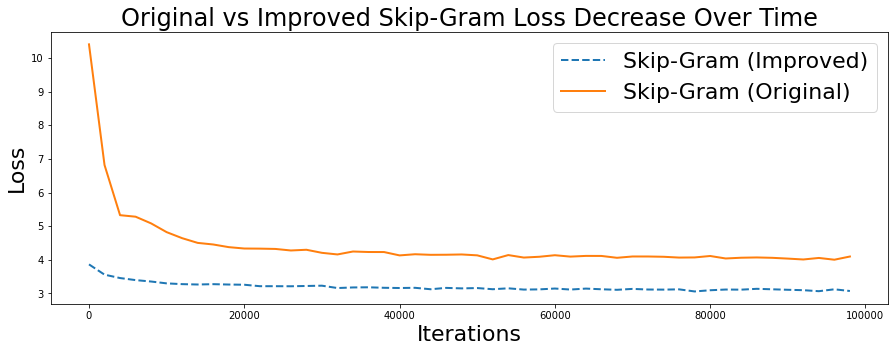

In [68]:
# Load the skip-gram losses from the calculations we did in Chapter 3
# So you need to make sure you have this csv file before running the code below
skip_loss_path = os.path.join('..','ch3','skip_losses.csv')
with open(skip_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            skip_gram_loss =  [float(s) for s in row]


pylab.figure(figsize=(15,5))  # figure in inches

# Define the x axis
x = np.arange(len(skip_gram_loss))*2000
  
# Plot the skip_gram_loss (loaded from chapter 3)
pylab.plot(x, skip_gram_loss, label="Skip-Gram (Improved)",linestyle='--',linewidth=2)    
# Plot the original skip gram loss from what we just ran
pylab.plot(x, skip_gram_loss_original, label="Skip-Gram (Original)",linewidth=2)

# Set some text around the plot
pylab.title('Original vs Improved Skip-Gram Loss Decrease Over Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)

# use for saving the figure if needed
pylab.savefig('loss_skipgram_original_vs_impr.jpg')
pylab.show()

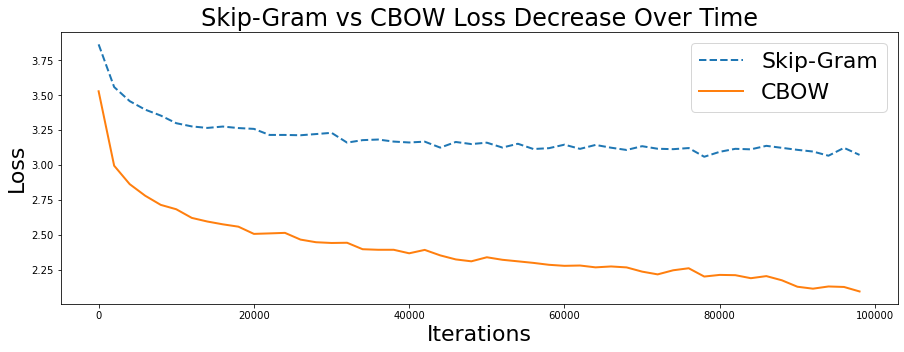

In [70]:
cbow_loss_path = os.path.join('..','ch3','cbow_losses.csv')
with open(cbow_loss_path, 'rt') as f:
    reader = csv.reader(f,delimiter=',')
    for r_i,row in enumerate(reader):
        if r_i == 0:
            cbow_loss =  [float(s) for s in row]

pylab.figure(figsize=(15,5))  # in inches
x = np.arange(len(skip_gram_loss))*2000
pylab.plot(x, skip_gram_loss, label="Skip-Gram",linestyle='--',linewidth=2)    
pylab.plot(x, cbow_loss, label="CBOW",linewidth=2)
pylab.title('Skip-Gram vs CBOW Loss Decrease Over Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)
pylab.savefig('loss_skipgram_vs_cbow.png')
pylab.show()

In [40]:
def find_clustered_embeddings(embeddings,distance_threshold,sample_threshold):
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

# Load the previously saved embeddings from Chapter 3 exercise
skip_emb_path = os.path.join('..','ch3','skip_embeddings.npy')
cbow_emb_path = os.path.join('..','ch3','cbow_embeddings.npy')

skip_gram_final_embeddings = np.load(skip_emb_path)
cbow_final_embeddings = np.load(cbow_emb_path)

num_points = 1000 # we will use a large sample space to build the T-SNE manifold and then prune it using cosine similarity

# Create a t-SNE object from scikit-learn
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)

print('Fitting embeddings to T-SNE (skip-gram and CBOW)')
# Get the T-SNE manifold for skip-gram embeddings
print('\tSkip-gram')
sg_selected_embeddings = skip_gram_final_embeddings[:num_points, :]
sg_two_d_embeddings = tsne.fit_transform(sg_selected_embeddings)

# Get the T-SNE manifold for CBOW embeddings
print('\tCBOW')
cbow_selected_embeddings = cbow_final_embeddings[:num_points, :]
cbow_two_d_embeddings = tsne.fit_transform(cbow_selected_embeddings)

print('Pruning the T-SNE embeddings (skip-gram and CBOW)')
# Prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
# Prune skip-gram
print('\tSkip-gram')
sg_selected_ids = find_clustered_embeddings(sg_selected_embeddings,.3,10)
sg_two_d_embeddings = sg_two_d_embeddings[sg_selected_ids,:]
# Prune CBOW
print('\tCBOW')
cbow_selected_ids = find_clustered_embeddings(cbow_selected_embeddings,.3,10)
cbow_two_d_embeddings = cbow_two_d_embeddings[cbow_selected_ids,:]

# Some stats about pruning
print('Out of ',num_points,' samples (skip-gram), ', sg_selected_ids.shape[0],' samples were selected by pruning')
print('Out of ',num_points,' samples (CBOW), ', cbow_selected_ids.shape[0],' samples were selected by pruning')

Fitting embeddings to T-SNE (skip-gram and CBOW)
	Skip-gram
	CBOW
Pruning the T-SNE embeddings (skip-gram and CBOW)
	Skip-gram
	CBOW
Out of  1000  samples (skip-gram),  166  samples were selected by pruning
Out of  1000  samples (CBOW),  279  samples were selected by pruning


Define Label colors for 20
Running K-Means for skip-gram
Running K-Means for CBOW
K-Means ran successfully
Plotting results


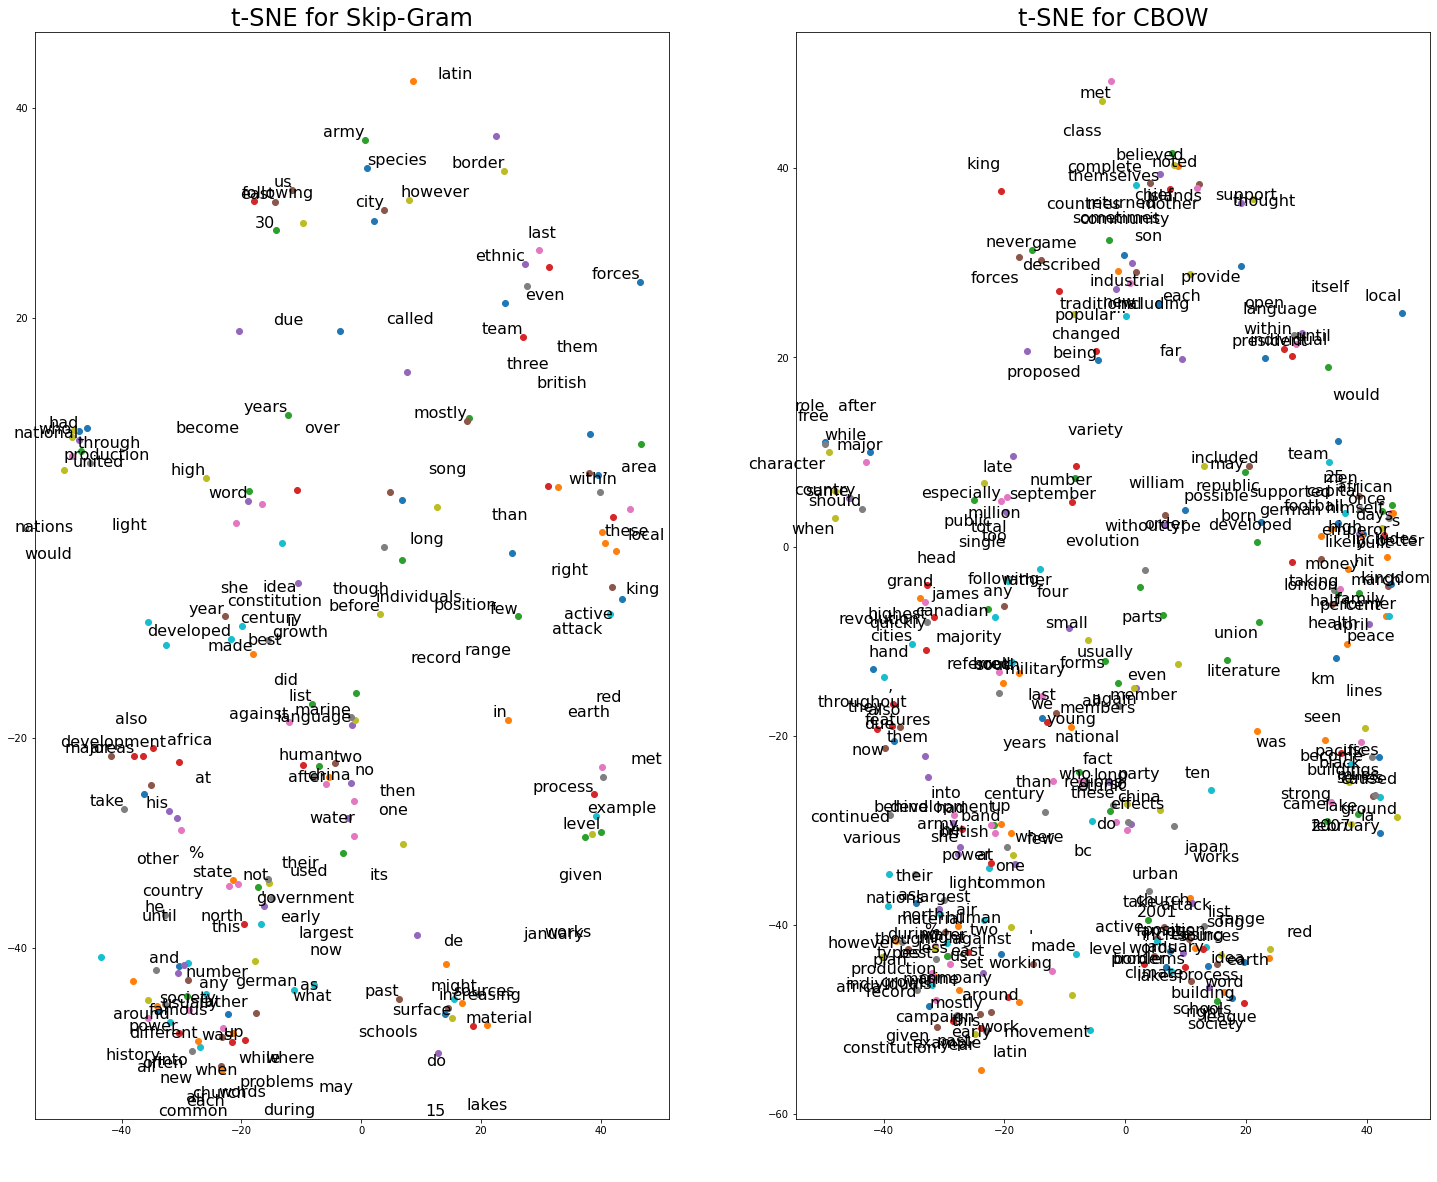

In [57]:
def plot_embeddings_side_by_side(sg_embeddings, cbow_embeddings, sg_labels, cbow_labels):
    n_clusters = 20 
    print('Define Label colors for %d'%n_clusters)
    label_colors = [pylab.cm.Spectral(float(i) /n_clusters) for i in range(n_clusters)]
  
    assert sg_embeddings.shape[0] >= len(sg_labels), 'More labels than embeddings'
    assert cbow_embeddings.shape[0] >= len(cbow_labels), 'More labels than embeddings'  
    print('Running K-Means for skip-gram')
    # Define K-Means
    sg_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(sg_embeddings)
    sg_kmeans_labels = sg_kmeans.labels_
    sg_cluster_centroids = sg_kmeans.cluster_centers_

    print('Running K-Means for CBOW')
    cbow_kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(cbow_embeddings)
    cbow_kmeans_labels = cbow_kmeans.labels_
    cbow_cluster_centroids = cbow_kmeans.cluster_centers_    
    print('K-Means ran successfully')
    print('Plotting results')
    pylab.figure(figsize=(25,20))  # in inches

    # Get the first subplot
    pylab.subplot(1, 2, 1) 
    # Plot all the embeddings and their corresponding words for skip-gram
    for i, (label,klabel) in enumerate(zip(sg_labels,sg_kmeans_labels)):
        center = sg_cluster_centroids[klabel,:]
        x, y = cbow_embeddings[i,:]    
        if x < center[0]:
            x += -abs(np.random.normal(scale=2.0))
        else:
            x += abs(np.random.normal(scale=2.0))        
        if y < center[1]:
            y += -abs(np.random.normal(scale=2.0))
        else:
            y += abs(np.random.normal(scale=2.0))
        
        pylab.scatter(x, y, cmap=label_colors[klabel])    
        x = x if np.random.random()<0.5 else x + 10
        y = y if np.random.random()<0.5 else y - 10
        pylab.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                   ha='right', va='bottom',fontsize=16)
    pylab.title('t-SNE for Skip-Gram',fontsize=24)
    
    # Get the second subplot
    pylab.subplot(1, 2, 2)  
    # Plot all the embeddings and their corresponding words for CBOW
    for i, (label,klabel) in enumerate(zip(cbow_labels,cbow_kmeans_labels)):
        center = cbow_cluster_centroids[klabel,:]
        x, y = cbow_embeddings[i,:]      
        if x < center[0]:
            x += -abs(np.random.normal(scale=2.0))
        else:
            x += abs(np.random.normal(scale=2.0))
        if y < center[1]:
            y += -abs(np.random.normal(scale=2.0))
        else:
            y += abs(np.random.normal(scale=2.0))
        pylab.scatter(x, y, cmap=label_colors[klabel])  
        x = x if np.random.random()<0.5 else x + np.random.randint(0,10)
        y = y + np.random.randint(0,5) if np.random.random()<0.5 else y - np.random.randint(0,5)
        pylab.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points',
                       ha='right', va='bottom',fontsize=16)
    pylab.title('t-SNE for CBOW',fontsize=24)
    # use for saving the figure if needed
    pylab.savefig('tsne_skip_vs_cbow.png')
    pylab.show()
    
# Run the function
sg_words = [reverse_dictionary[i] for i in sg_selected_ids]
cbow_words = [reverse_dictionary[i] for i in cbow_selected_ids]
plot_embeddings_side_by_side(sg_two_d_embeddings, cbow_two_d_embeddings, sg_words,cbow_words)

# CBOW Algorithm

In [60]:
data_index = 0

def generate_batch_cbow(batch_size, window_size):
    global data_index
    span = 2 * window_size + 1 # [ skip_window target skip_window ]
    # batch = np.ndarray(shape=(batch_size), dtype=np.int32) 
    # cbow 演算法比 Skip-gram 多了 2*window_size 的 input維度
    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    for i in range(batch_size):
        target = window_size
        target_to_avoid = [ window_size ] # we only need to know the words around a given word, not the word itself        
        col_idx = 0
        for j in range(span):
            # ignore the target word when creating the batch
            if j==span//2:
                continue
            batch[i,col_idx] = buffer[j] 
            col_idx += 1
        labels[i, 0] = buffer[target]
        
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    return batch, labels

for window_size in [1,2]:
    data_index = 0
    batch, labels = generate_batch_cbow(batch_size=8, window_size=window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

word_count_dictionary = {}
unigrams = [0 for _ in range(vocabulary_size)]
for word,w_count in count:
    w_idx = dictionary[word]
    unigrams[w_idx] = w_count*1.0/token_count
    word_count_dictionary[w_idx] = w_count
print('\nFirst 10 Unigram probabilities')
print(unigrams[:10])


with window_size = 1:
    batch: [['propaganda', 'a'], ['is', 'UNK'], ['a', 'set'], ['UNK', 'of'], ['set', 'UNK'], ['of', 'aimed'], ['UNK', 'at'], ['aimed', 'UNK']]
    labels: ['is', 'a', 'UNK', 'set', 'of', 'UNK', 'aimed', 'at']

with window_size = 2:
    batch: [['propaganda', 'is', 'UNK', 'set'], ['is', 'a', 'set', 'of'], ['a', 'UNK', 'of', 'UNK'], ['UNK', 'set', 'UNK', 'aimed'], ['set', 'of', 'aimed', 'at'], ['of', 'UNK', 'at', 'UNK'], ['UNK', 'aimed', 'UNK', 'the'], ['aimed', 'at', 'the', 'UNK']]
    labels: ['a', 'UNK', 'set', 'of', 'UNK', 'aimed', 'at', 'UNK']
First 10 Unigram probabilities
[0.14885340500587138, 0.06750330907324231, 0.05474600984823039, 0.03597481028426345, 0.03460744677591096, 0.026371134468419585, 0.023147595823293555, 0.019527771670524895, 0.017548129202166005, 0.009180614260387545]


In [63]:
tf.reset_default_graph()
train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*window_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0,dtype=tf.float32))
softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                 stddev=0.5 / math.sqrt(embedding_size),dtype=tf.float32))
softmax_biases = tf.Variable(tf.random_uniform([vocabulary_size],0.0,0.01))

stacked_embedings = None
print('Defining %d embedding lookups representing each word in the context'%(2*window_size))
for i in range(2*window_size):
    embedding_i = tf.nn.embedding_lookup(embeddings, train_dataset[:,i])        
    x_size,y_size = embedding_i.get_shape().as_list()
    if stacked_embedings is None:
        stacked_embedings = tf.reshape(embedding_i,[x_size,y_size,1])
    else:
        stacked_embedings = tf.concat(axis=2,values=[stacked_embedings,tf.reshape(embedding_i,[x_size,y_size,1])])

assert stacked_embedings.get_shape().as_list()[2]==2*window_size
print("Stacked embedding size: %s"%stacked_embedings.get_shape().as_list())
mean_embeddings =  tf.reduce_mean(stacked_embedings,2,keepdims=False)
print("Reduced mean embedding size: %s"%mean_embeddings.get_shape().as_list())

# Compute the softmax loss, using a sample of the negative labels each time.
# inputs are embeddings of the train words
# with this loss we optimize weights, biases, embeddings

# However, unlike at the previous instance (Chapter 3) we use a different sample to sampel negative classes
# Particularly we use a unigram candidate sampler, to which we provide
# the unigram probabilities we computed earlier. For details about the passed arguments
# Refer the text in Chapter 4
candidate_sampler = tf.nn.fixed_unigram_candidate_sampler(true_classes = tf.cast(train_labels,dtype=tf.int64), num_true = 1, 
                                      num_sampled = num_sampled, 
                                      unique = True, range_max = vocabulary_size, 
                                      distortion=0.75, 
                                      num_reserved_ids=0, 
                                      unigrams=unigrams, name='unigram_sampler')

# The loss is very similar to what we defined in Chapter 3, except for
# passing the above defined sampler to the function.
loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=mean_embeddings,
                           labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size,
                              sampled_values=candidate_sampler))

optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
normalized_embeddings = embeddings / norm
valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Defining 4 embedding lookups representing each word in the context
Stacked embedding size: [24, 24, 4]
Reduced mean embedding size: [24, 24]
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



## Running CBOW with Unigram Candidate Sampling

Here we run the CBOW algorithm with unigram based candidate sampling, we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [64]:
cbow_loss_unigram = []

tStart= time.time()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    tf.global_variables_initializer().run()
    print('Initialized', time.strftime('%H:%M:%S',time.localtime()))    
    average_loss = 0    
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)        
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000                
            cbow_loss_unigram.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0           
        
        if (step+1) % 10000 == 0:
            print(time.strftime('%H:%M:%S',time.localtime()))
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()    

tEnd = time.time()
print('Cost %.2f seconds'%(tEnd-tStart))
with open('cbow_unigram_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_loss_unigram)

Initialized 17:55:39
Average loss at step 2000: 2.877750
Average loss at step 4000: 2.723959
Average loss at step 6000: 2.689628
Average loss at step 8000: 2.646057
Average loss at step 10000: 2.577616
17:55:S
Nearest to for: quantity, from, d., during, under, der, ongoing, about,
Nearest to of: around, during, d., before, philippines, median, bang, executive,
Nearest to and: or, suburb, interstate, annual, including, numerous, center, ..,
Nearest to .: ;, technique, philosopher, barrier, partly, helped, pound, steam,
Nearest to is: was, became, told, are, franklin, collected, ceased, ban,
Nearest to :: tate, ;, leone, copy, k, 1957, remain, leaders,
Nearest to with: or, under, without, defensive, picasso, but, interstate, and,
Nearest to its: their, his, large-scale, three, dramatic, the, realized, texas,
Nearest to but: however, solid, including, potential, which, praised, where, or,
Nearest to first: vietnamese, soul, au, sustained, going, song, primary, museum,
Nearest to '': globu

Average loss at step 62000: 2.296858
Average loss at step 64000: 2.290070
Average loss at step 66000: 2.301264
Average loss at step 68000: 2.301839
Average loss at step 70000: 2.293799
17:56:S
Nearest to for: without, under, onto, despite, gave, before, from, involves,
Nearest to of: concerning, featuring, tax, comprising, regarding, cast, containing, remaining,
Nearest to and: or, .., while, but, including, where, disorder, allowing,
Nearest to .: ;, -, ,, :, sees, —, .., 2006.,
Nearest to is: was, are, contains, allows, remains, becomes, extends, became,
Nearest to :: i., ..., ., involving, tate, !, ;, -,
Nearest to with: using, maintains, through, possess, without, via, like, under,
Nearest to its: their, his, the, her, our, training, my, another,
Nearest to but: though, while, however, particularly, although, which, where, especially,
Nearest to first: last, award, best, next, following, longest, mourning, box,
Nearest to '': replied, beautiful, called, finnish, o, admiral, globula

## Generating Word Sequence with Subsampling

In [65]:
subsampled_data = []
drop_count = 0
drop_examples = []

# Here we traverse through the data and drop irrelavent words
# according to the subsampling probability 
for w_i in data:
    # Note that the paper uses t=1e-5
    # This is fine when using a normalized frequency of words
    # But we are using raw frequencies so we set t=1e5
    p_w_i = 1 - np.sqrt(1e5/word_count_dictionary[w_i])
    
    if np.random.random() < p_w_i:
        drop_count += 1
        drop_examples.append(reverse_dictionary[w_i])
    else:
        subsampled_data.append(w_i)
        
# Print some statistics
print('Dropped %d%% words (%d words) in total...'%(drop_count*100.0/len(data),drop_count))
print('Dropped Examples: ', drop_examples[:20])
print('\nOriginal data: ',[reverse_dictionary[w_i] for w_i in data[:20]])
print('\nSubsampled data: ',[reverse_dictionary[w_i] for w_i in subsampled_data[:20]])

Dropped 12% words (420437 words) in total...
Dropped Examples:  ['UNK', 'UNK', 'UNK', 'of', 'of', 'UNK', ',', 'the', 'UNK', 'UNK', 'UNK', 'the', 'UNK', 'the', 'UNK', 'UNK', 'the', 'UNK', 'UNK', 'UNK']

Original data:  ['propaganda', 'is', 'a', 'UNK', 'set', 'of', 'UNK', 'aimed', 'at', 'UNK', 'the', 'UNK', 'or', 'behavior', 'of', 'large', 'numbers', 'of', 'people', '.']

Subsampled data:  ['propaganda', 'is', 'a', 'UNK', 'set', 'of', 'aimed', 'at', 'the', 'or', 'behavior', 'large', 'numbers', 'of', 'people', '.', 'instead', 'providing', 'information', 'propaganda']


## Running CBOW with Unigram Sampling + Subsampling

Here we run the CBOW with unigram sampling and subsampling which we defined above. Specifically, we first initialize variables, and then train the algorithm for many steps (`num_steps`). And every few steps we evaluate the algorithm on a fixed validation set and print out the words that appear to be closest for a given set of words.

In [66]:
cbow_loss_unigram_subsampled = []
tStart = time.time()

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as session:
    tf.global_variables_initializer().run()
    print('Initialized',time.strftime('%H:%M:%S',time.localtime()))    
    average_loss = 0
    for step in range(num_steps):        
        batch_data, batch_labels = generate_batch_cbow(batch_size, window_size)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        
        if (step+1) % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000                
            cbow_loss_unigram_subsampled.append(average_loss)
            print('Average loss at step %d: %f' % (step+1, average_loss))
            average_loss = 0
        
        if (step+1) % 10000 == 0:
            print(time.strftime('%H:%M:%S',time.localtime()))
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    cbow_final_embeddings = normalized_embeddings.eval()
    
tEnd = time.time()
print('Cost %.2f seconds'%(tEnd-tStart))
with open('cbow_unigram_subsampled_losses.csv', 'wt') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(cbow_loss_unigram_subsampled)

Initialized 18:48:11
Average loss at step 2000: 2.874575
Average loss at step 4000: 2.692981
Average loss at step 6000: 2.645544
Average loss at step 8000: 2.584488
Average loss at step 10000: 2.582542
18:48:34
Nearest to for: include, neighboring, &, associate, atlantic, lose, involves, --,
Nearest to of: recalled, ukrainian, venus, win, towards, despite, keeping, consider,
Nearest to and: or, baltimore, wounded, which, safety, varying, with, reflected,
Nearest to .: ;, —, allows, ,, desire, :, militia, largest,
Nearest to is: was, are, were, 1990, became, stopped, effectively, michelangelo,
Nearest to :: ;, =, clearly, produced, ., famous, liberals, basel,
Nearest to with: or, under, and, where, childhood, societies, gross, christian,
Nearest to its: their, his, the, train, an, cable, mumbai, another,
Nearest to but: which, where, yarralumla, while, especially, who, including, however,
Nearest to first: components, prominent, last, adopted, nervous, remain, neighbouring, cost,
Neares

Average loss at step 62000: 2.333607
Average loss at step 64000: 2.317574
Average loss at step 66000: 2.304830
Average loss at step 68000: 2.304564
Average loss at step 70000: 2.279648
18:51:04
Nearest to for: regarding, after, during, of, towards, without, concerning, involves,
Nearest to of: amongst, administrative, involves, for, toward, comprises, real, towards,
Nearest to and: or, but, whereas, while, including, &, entering, causing,
Nearest to .: ;, —, ,, --, .., 2005., recorded, :,
Nearest to is: was, are, exists, makes, reflects, provides, becomes, includes,
Nearest to :: primitive, }, and/or, =, ;, <, ..., .,
Nearest to with: like, wear, comprising, rival, without, warehouse, concerning, including,
Nearest to its: their, our, the, his, cups, any, another, motor,
Nearest to but: while, though, whereas, which, and, nor, particularly, however,
Nearest to first: last, next, following, final, magazine, initial, studio, underlying,
Nearest to '': tobacco, shells, i, martial, so-call

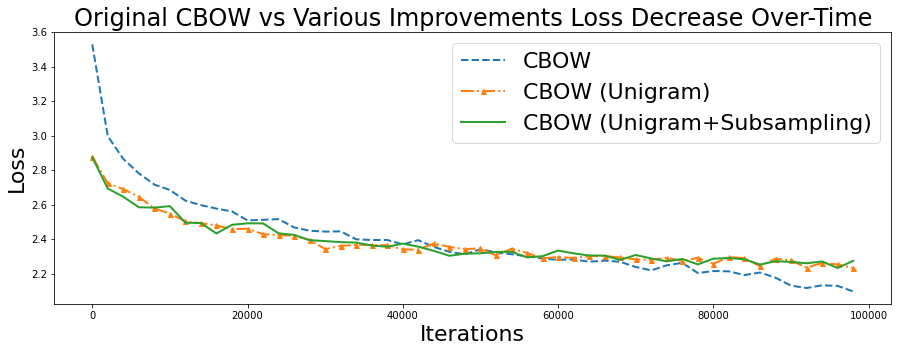

In [71]:
pylab.figure(figsize=(15,5))  # in inches

# Define the x axis
x = np.arange(len(skip_gram_loss))*2000
pylab.plot(x, cbow_loss, label="CBOW",linestyle='--',linewidth=2)
pylab.plot(x, cbow_loss_unigram, label="CBOW (Unigram)",linestyle='-.',linewidth=2,marker='^',markersize=5)
pylab.plot(x, cbow_loss_unigram_subsampled, label="CBOW (Unigram+Subsampling)",linewidth=2)
pylab.title('Original CBOW vs Various Improvements Loss Decrease Over-Time',fontsize=24)
pylab.xlabel('Iterations',fontsize=22)
pylab.ylabel('Loss',fontsize=22)
pylab.legend(loc=1,fontsize=22)
pylab.savefig('loss_cbow_vs_all_improvements.png')
pylab.show()